<a href="https://colab.research.google.com/github/0BVer/sch_AI/blob/main/sentiment_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 예측

In [1]:
cd /content/drive/MyDrive/Colab Notebooks/data

/content/drive/MyDrive/Colab Notebooks/data


In [2]:
from keras.models import load_model
model = load_model('trained_model(epoch=6batch_size=64).h5')

In [3]:
import pandas as pd

df = pd.read_csv("Reviews.csv")
df = df[df['Score'] != 3]
df['sentiment'] = df['Score'].apply(lambda rating : 'positive' if rating > 3 else 'negative')
review_df1 = df[['Text', 'sentiment']]
test_sets1=review_df1.Text.values

df = pd.read_csv("Tweets.csv")
review_df2 = df[['text', 'airline_sentiment']]
review_df2 = review_df2[review_df2['airline_sentiment'] != 'neutral']
review_df2.columns = ["Text", "sentiment"]
test_sets2=review_df2.Text.values

review_df = pd.concat([review_df1, review_df2], ignore_index = True)
test_sets=review_df.Text.values
sentiment_label = review_df.sentiment.factorize()
answers = review_df.sentiment.values
length=len(test_sets1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=15000)
tokenizer.fit_on_texts(test_sets)

encoded_docs = tokenizer.texts_to_sequences(test_sets)

In [5]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
padded_sequence = pad_sequences(encoded_docs, maxlen = 200)

def predict_sentiment(text):
  tw = tokenizer.texts_to_sequences([text])
  tw = pad_sequences(tw, maxlen=200)
  prediction = int(model.predict(tw).round().item())
  return sentiment_label[1][prediction]


In [6]:
test_sentence1 = "I enjoy my trip on this flight."

print(predict_sentiment(test_sentence1))

positive


# 분류

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
18084 positive negative 17052/18084
18087 positive negative 17054/18087
18099 positive negative 17065/18099
18109 positive negative 17074/18109
18112 positive negative 17076/18112
18117 positive negative 17080/18117
18125 positive negative 17087/18125
18132 positive negative 17093/18132
18133 positive negative 17093/18133
18144 positive negative 17103/18144
18151 positive negative 17109/18151
18168 positive negative 17125/18168
18184 positive negative 17140/18184
18201 positive negative 17156/18201
18204 positive negative 17158/18204
18211 positive negative 17164/18211
18219 negative positive 17171/18219
18230 positive negative 17181/18230
18242 positive negative 17192/18242
18244 positive negative 17193/18244
18245 positive negative 17193/18245
18247 positive negative 17194/18247
18250 positive negative 17196/18250
18298 positive negative 17243/18298
18303 negative positive 17247/18303
16000 2304
18314 positive negative 17257/18314
18352 negative po

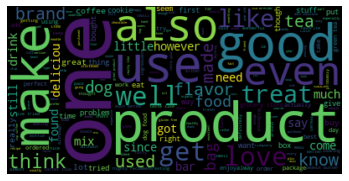

In [7]:
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

nltk.download('stopwords')
stopwords = set(stopwords.words('english'))
stopwords.update(["br", "href", "would"])

positives=dict()
negatives=dict()
pos_cnt=0
neg_cnt=0
cnt=0

meta_text=""
pos_meta_text=""
neg_meta_text=""

for i in range(100000):
  text=re.sub('^@[a-zA-Z0-9]*','',test_sets1[i])
  words=text.split(' ')
  words=[word for word in words if word not in stopwords]
  text=' '.join(words)
  text=''.join(list(filter(lambda x : x not in "!@#$%^&*())-='",text)))
  text=str(text).lower()
  text=re.sub('\[.*?\]', '',text)
  text=re.sub('https?://\S+|www\.\S+','',text)
  text=re.sub('<.*?>+','',text)
  text=re.sub(r'[^\w\s]','',text)
  text=re.sub('\n','',text)
  text=re.sub('\w*\d\w*','',text)
  result=predict_sentiment(text)

  words=text.split(' ')
  words=list(filter(None, words))
  words=[word for word in words if word not in stopwords]

  text=" ".join(words)
  meta_text+=text+" "

  if result=='positive':
    pos_cnt+=1
    for word in words:
      if word in positives:
        positives[word]+=1
      else:
        positives[word]=1
    pos_meta_text+=text+" "

  else:
    neg_cnt+=1
    for word in words:
      if word in negatives:
        negatives[word]+=1
      else:
        negatives[word]=1
    neg_meta_text+=text+" "
  
  if pos_cnt%500==0 or neg_cnt%500==0:
    print(pos_cnt, neg_cnt)
  if result==answers[i]:
    cnt+=1
  else:
    print(i+1,result,answers[i],"%d/%d"%(cnt,i+1))

import matplotlib.pyplot as plt

wordcloud = WordCloud(stopwords=stopwords).generate(meta_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud_total.png', pad_inches=0.1)
plt.show() 

In [8]:
import operator

positives=dict(positives)
negatives=dict(negatives)

sPositives=sorted(positives.items(), key=operator.itemgetter(1),reverse=True)
sNegatives=sorted(negatives.items(), key=operator.itemgetter(1),reverse=True)

sPositives=dict(sPositives)
sNegatives=dict(sNegatives)

pos_keys=list(sPositives.keys())
pos_values=list(sPositives.values())
neg_keys=list(sNegatives.keys())
neg_values=list(sNegatives.values())

top_pos_keys=pos_keys[:80]
top_pos_cnt=pos_values[:80]
top_neg_keys=neg_keys[:80]
top_neg_cnt=neg_values[:80]

cnt=0
i=0
while i < len(top_pos_keys):
  if top_pos_keys[i] in top_neg_keys:
    j=top_neg_keys.index(top_pos_keys[i])
    del top_pos_keys[i]
    del top_pos_cnt[i]
    del top_neg_keys[i]
    del top_neg_cnt[i]

  else:
    i+=1

print(top_pos_keys)

['taste', 'product', 'food', 'really', 'best', 'amazon', 'tried', 'dog', 'eat', 'even', 'try', 'bag', 'first', 'sweet', 'water', 'delicious', 'recommend', 'favorite', 'day', 'bit', 'nice', 'store', 'two', 'go', 'bought', 'loves', 'chips', 'still', 'could', 'every', 'flavors', 'mix', 'box', 'without', 'know', 'treats', 'always', 'add', 'perfect', 'hot', 'makes', 'snack']


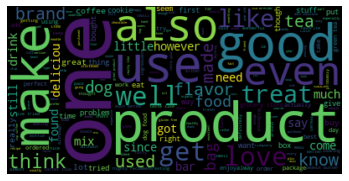

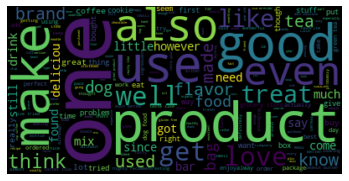

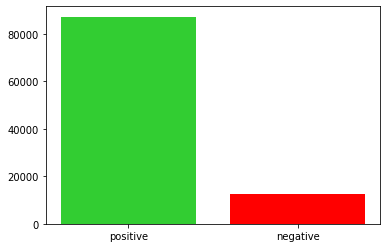

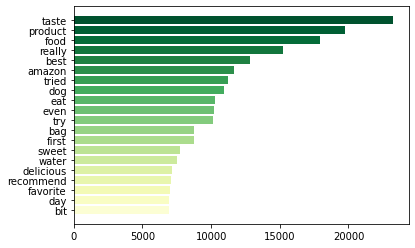

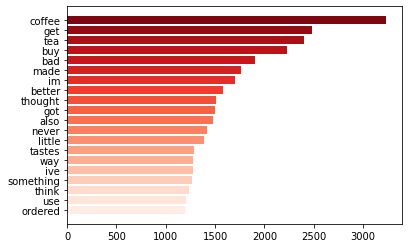

In [9]:
worldcloud = WordCloud(stopwords=stopwords).generate(' '.join(top_pos_keys))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud_pos.png', pad_inches=0.1)
plt.show()

worldcloud = WordCloud(stopwords=stopwords).generate(' '.join(top_neg_keys))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud_neg.png', pad_inches=0.1)
plt.show()

import matplotlib.pyplot as plt
import seaborn as sns

X=['positive', 'negative']
freq=[pos_cnt, neg_cnt]

plt.bar(X, freq, color=['limegreen', 'red'])
plt.savefig('./count.png', dpi=200, bbox_inches='tight', pad_inches=0.1)
plt.show()

top_pos_keys=top_pos_keys[:20]
top_pos_cnt=top_pos_cnt[:20]

top_neg_keys=top_neg_keys[:20]
top_neg_cnt=top_neg_cnt[:20]

colors=sns.color_palette('YlGn', 20)
plt.barh(top_pos_keys[::-1], top_pos_cnt[::-1], color=colors)
plt.savefig('./positive.png', dpi=200, bbox_inches='tight', pad_inches=0.1)
plt.show()

colors=sns.color_palette('Reds', 20)
plt.barh(top_neg_keys[::-1], top_neg_cnt[::-1], color=colors)
plt.savefig('./negative.png', dpi=200, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [11]:
!pip install python-docx

     |████████████████████████████████| 5.6 MB 6.6 MB/s 
  Created wheel for python-docx: filename=python_docx-0.8.11-py3-none-any.whl size=184508 sha256=79360e60e8560bf91ae59f30d2751989da5ce890c3eac18e3e69af3f3f6b7028
  Stored in directory: /root/.cache/pip/wheels/f6/6f/b9/d798122a8b55b74ad30b5f52b01482169b445fbb84a11797a6
Successfully built python-docx


In [12]:
from docx import Document
from docx.shared import Inches, Pt

document = Document()
document.add_heading('Sentiment Analysis Result', level = 0)
p = document.add_paragraph(style='ListNumber')
p.add_run().font.size=Pt(12)
p.add_run('Classification').bold=True
document.add_picture('count.png', width=Inches(5.5))
p = document.add_paragraph("The number of positive response: "+str(pos_cnt)+" ("+str(round(pos_cnt*100/(pos_cnt+neg_cnt),2))+"%)")
p = document.add_paragraph("The number of negative response: "+str(neg_cnt)+" ("+str(round(neg_cnt*100/(pos_cnt+neg_cnt),2))+"%)")
document.add_picture('wordcloud_total.png', width=Inches(5))

# Positive
p = document.add_paragraph(style='ListNumber')
p.add_run('Positive').bold=True
p = document.add_paragraph("The number of positive response: "+str(pos_cnt), style='ListBullet2')
p = document.add_paragraph("Top 20 frequent words: ", style='ListBullet2')
document.add_picture('positive.png', width=Inches(5.5))

table = document.add_table(rows=21, cols=2, style="Table Grid")
for i in range(21):
  table.cell(i,0).width=Inches(1.25)
  table.cell(i,1).width=Inches(1.25)

table.rows[0].cells[0].text = "word"
table.rows[0].cells[1].text = "count"

for i in range(20):
  table.rows[0].cells[0].text=top_pos_keys[i]
  table.rows[0].cells[1].text=str(top_pos_cnt[i])

document.add_picture('wordcloud_pos.png', width=Inches(5))
document.add_page_break()

#Negative
p = document.add_paragraph(style='ListNumber')
p.add_run('Negative').bold=True
p = document.add_paragraph("The number of negative response: "+str(neg_cnt), style='ListBullet2')
p = document.add_paragraph("Top 20 frequent words: ", style='ListBullet2')
document.add_picture('negative.png', width=Inches(5.5))

table = document.add_table(rows=21, cols=2, style="Table Grid")
for i in range(21):
  table.cell(i,0).width=Inches(1.25)
  table.cell(i,1).width=Inches(1.25)

table.rows[0].cells[0].text = "word"
table.rows[0].cells[1].text = "count"

for i in range(20):
  table.rows[0].cells[0].text=top_neg_keys[i]
  table.rows[0].cells[1].text=str(top_neg_cnt[i])

document.add_picture('wordcloud_neg.png', width=Inches(5))

document.save("result.docx")

/usr/local/lib/python3.7/dist-packages/docx/styles/styles.py:139: UserWarning: style lookup by style_id is deprecated. Use style name as key instead.
  return self._get_style_id_from_style(self[style_name], style_type)
